# Load results in dataframe

In [ ]:
import pandas as pd

def add_loss_columns(csv_path, model_name_column='model_name'):
    """
    Loads a CSV file, reads the model names, and creates binary columns for included loss functions.
    
    Args:
        csv_path (str): Path to the CSV file.
        model_name_column (str): Name of the column containing the model name.
        
    Returns:
        pd.DataFrame: The extended DataFrame with binary columns for loss functions.
    """
    # List of known loss components (you can extend this)
    known_losses = ['ITM', 'SimCLR', 'MLM', 'CLIP']

    # Load CSV
    df = pd.read_csv(csv_path)

    # Model names in uppercase for more robust detection
    model_names = df[model_name_column].fillna("").str.upper()

    # Add binary columns
    for loss in known_losses:
        df[loss] = model_names.str.contains(loss.upper()).astype(int)

    return df


In [2]:
zeroshot_fpath = "../../test_results/model_scores_zero-shot.csv"
probe_fpath = "../../test_results/model_scores_linear_probe.csv"
retrieval_fpath = "../../test_results/model_scores_retrieval.csv"

In [3]:
df_zeroshot = add_loss_columns(zeroshot_fpath, model_name_column="model_name")
df_probe = add_loss_columns(probe_fpath, model_name_column="model_name")
df_retrieval = add_loss_columns(retrieval_fpath, model_name_column="model")

# Regression

In [ ]:
import statsmodels.api as sm

def run_multiple_regression(
    df, 
    target_col='score', 
    feature_cols=['CLIP', 'ITM', 'SimCLR', 'MLM'],
    metric=None,
    method_notes=None,
    dataset_fraction=None,
    ):
    """
    Performs multiple linear regression.

    Parameters:
    - df: DataFrame with the data (loss functions as 0/1 in feature_cols, target variable in target_col)
    - target_col: Name of the target variable column (e.g. 'score' or 'difference')
    - feature_cols: List of loss function columns (binary encoded)

    Returns:
    - results: statsmodels regression result object
    """
    if metric is not None:
    df = df[df['metric'] == metric]
    if method_notes is not None:
    df = df[df['method_notes'] == method_notes]
    if dataset_fraction is not None:
    df = df[df['dataset_fraction'] == dataset_fraction]
    X = df[feature_cols]
    y = df[target_col]

    # Add constant term (intercept)
    X = sm.add_constant(X)

    # Fit regression
    model = sm.OLS(y, X).fit()

    return model

# Example call
# model = run_multiple_regression(df, target_col='difference')
# print(model.summary())


In [4]:
model = run_multiple_regression(
    df_zeroshot,
    target_col='score',
    metric="Top1Accuracy",
    method_notes="1_templates",
    dataset_fraction="1-aug",
)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     14.48
Date:                Sat, 31 May 2025   Prob (F-statistic):           4.94e-10
Time:                        13:11:39   Log-Likelihood:                 66.448
No. Observations:                 156   AIC:                            -122.9
Df Residuals:                     151   BIC:                            -107.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0264      0.040      0.663      0.5

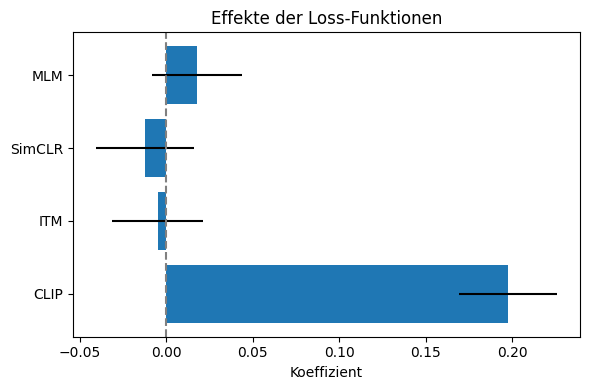

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

coefs = model.params.drop('const')
errors = model.bse.drop('const')

plt.figure(figsize=(6, 4))
plt.barh(coefs.index, coefs.values, xerr=errors.values, align='center')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Coefficient")
plt.title("Effects of Loss Functions")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import statsmodels.api as sm
import re

def fit_regression_for_task(df: pd.DataFrame, task: str, metric: str, dataset_fraction: str) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    Performs a regression for the given task, specified metric, and dataset_fraction.
    
    task: "zeroshot", "linear_probe" or "retrieval"
    metric: e.g. "Top1Accuracy", "image_retrieval_recall@1", ...
    dataset_fraction: e.g. "1.0" or "1-aug" (for retrieval this must be contained in the 'model' column)
    
    Returns: fitted regression model (statsmodels)
    """
    if task in ["zeroshot", "linear"]:
        df_sub = df[
            (df["method"] == task) &
            (df["metric"] == metric) &
            (df["dataset_fraction"] == dataset_fraction)
        ]
        y = df_sub["score"]
    
    elif task == "retrieval":
        # dataset_fraction is in the model string, e.g. CLIP-SimCLR-ITM_1-aug
        df_sub = df[
            (df["task"] == "zeroshot_retrieval") &
            (df["model"].str.contains(f"_{re.escape(dataset_fraction)}$"))  # _1-aug at the end
        ]
        if metric not in df_sub.columns:
            raise ValueError(f"Metric '{metric}' not found in DataFrame columns.")
        y = df_sub[metric]
    
    else:
        raise ValueError(f"Unknown task: {task}")

    if df_sub.empty:
        raise ValueError("Filtered DataFrame is empty. Please check the filter criteria.")

    # Feature matrix
    X = df_sub[["ITM", "SimCLR", "MLM", "CLIP"]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    return model


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_coefficients_heatmap(models_dict: dict, title: str = "Regression Coefficients"):
    """
    Takes a dict {task_name: fitted_model} and plots a heatmap of the coefficients.
    """
    records = []

    for subtask, model in models_dict.items():
        for loss in ["ITM", "SimCLR", "MLM", "CLIP"]:
            coef = model.params.get(loss, None)
            if coef is not None:
                records.append({
                    "task": subtask,
                    "loss_function": loss,
                    "coefficient": coef
                })

    df_coef = pd.DataFrame(records)
    heatmap_data = df_coef.pivot(index="loss_function", columns="task", values="coefficient")

    plt.figure(figsize=(max(10, len(models_dict) * 0.6), 5))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".3f")
    plt.title(title)
    plt.ylabel("Loss Function")
    plt.xlabel("Task / Subtask")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return df_coef


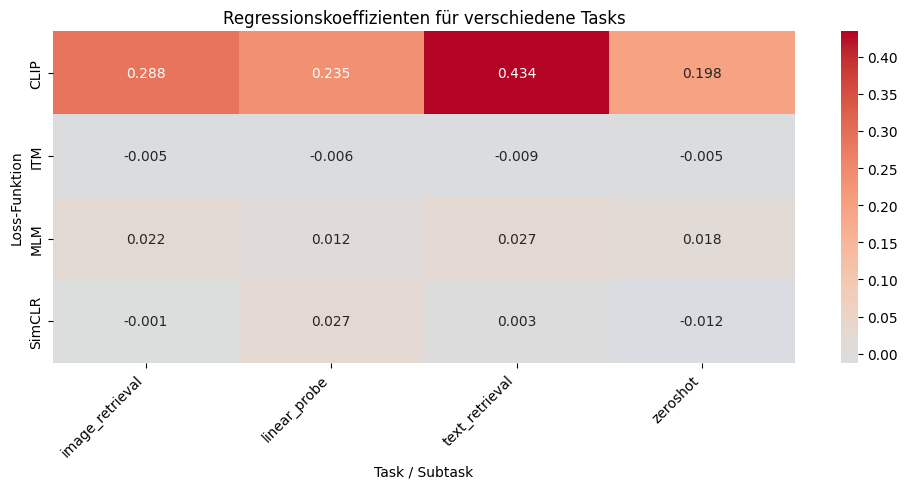

In [ ]:
regression_models = {
    "zeroshot": fit_regression_for_task(
        df_zeroshot, 
        task="zeroshot", 
        metric="Top1Accuracy", 
        dataset_fraction="1-aug"
    ),
    "linear_probe": fit_regression_for_task(
        df_probe, 
        task="linear", 
        metric="Top1Accuracy", 
        dataset_fraction="1-aug"
    ),
    "image_retrieval": fit_regression_for_task(
        df_retrieval, 
        task="retrieval", 
        metric="image_retrieval_recall@1", 
        dataset_fraction="1-aug"
    ),
    "text_retrieval": fit_regression_for_task(
        df_retrieval, 
        task="retrieval", 
        metric="text_retrieval_recall@1", 
        dataset_fraction="1-aug"
    )
}

# Plot the coefficient heatmap
df_coef = plot_coefficients_heatmap(regression_models, title="Regression coefficients for different tasks")

In [ ]:
def print_significant_coefficients(model, alpha=0.05):
    """
    Prints the coefficients with p-values less than alpha.
    """
    summary = model.summary2().tables[1]  # Table with coefficients
    significant = summary[summary['P>|t|'] < alpha]
    
    if significant.empty:
        print(f"No significant coefficients at alpha = {alpha}")
    else:
        print(f"Significant coefficients at alpha = {alpha}:")
        print(significant[['Coef.', 'Std.Err.', 't', 'P>|t|']])


In [31]:
model = fit_regression_for_task(df_zeroshot, task="zeroshot", metric="Top1Accuracy", dataset_fraction="1-aug")
print_significant_coefficients(model)

Signifikante Koeffizienten bei alpha = 0.05:
         Coef.  Std.Err.         t         P>|t|
CLIP  0.197512  0.028191  7.006276  7.570179e-11


In [ ]:
def extract_coefficients(model, task_name):
    """
    Returns a DataFrame with coefficients, p-values, and task names.
    """
    summary = model.summary2().tables[1]
    summary = summary.rename(columns={
        'Coef.': 'coef',
        'P>|t|': 'pval',
        'Std.Err.': 'stderr'
    })
    summary['task'] = task_name
    return summary.reset_index().rename(columns={'index': 'loss'})


In [ ]:
models = {
    'zeroshot': fit_regression_for_task(df_zeroshot, task='zeroshot', metric='Top1Accuracy', dataset_fraction='1-aug'),
    'linear_probe': fit_regression_for_task(df_probe, task='linear', metric='Top1Accuracy', dataset_fraction='1-aug'),
    'retrieval_text': fit_regression_for_task(df_retrieval, task='retrieval', metric='text_retrieval_recall@1', dataset_fraction='1-aug'),
    'retrieval_image': fit_regression_for_task(df_retrieval, task='retrieval', metric='image_retrieval_recall@1', dataset_fraction='1-aug'),
}

all_coeffs = pd.concat([extract_coefficients(model, task_name) for task_name, model in models.items()])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_coefficient_heatmap(df, alpha=0.05):
    # Pivot for heatmap
    pivot = df.pivot(index='loss', columns='task', values='coef')

    # Mask for non-significant fields
    mask = df.pivot(index='loss', columns='task', values='pval') >= alpha

    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", center=0)
    plt.title("Significant coefficients (p < {:.2f})".format(alpha))
    plt.tight_layout()
    plt.show()


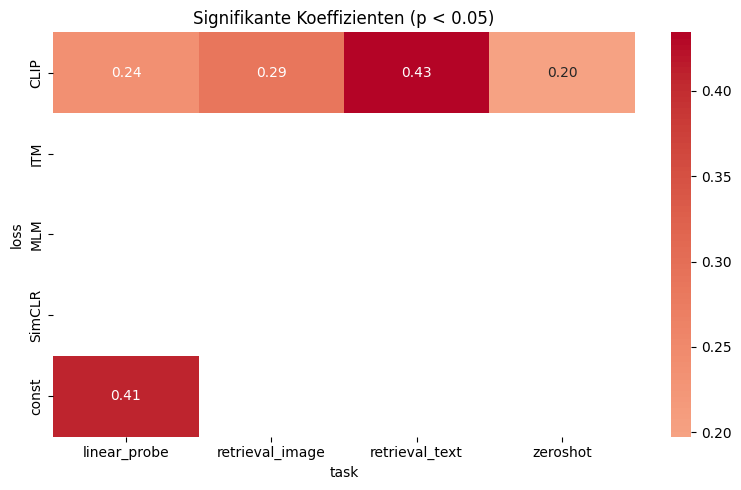

In [36]:
plot_coefficient_heatmap(all_coeffs, alpha=0.05)